### Fruit Classification Using Transfer Learning

In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scikit-learn

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import scipy
import sklearn
import os
import subprocess
import zipfile

# Definir la URL del conjunto de datos y las rutas locales
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
archivo_zip_local = "fruits-360-original-size.zip"
directorio_extraccion = "fruits-360-original-size"

def descargar_dataset(url, archivo_salida):
    """Descargar el conjunto de datos usando wget en modo silencioso."""
    print("Descargando el conjunto de datos...")
    subprocess.run(["wget", "-q", "-O", archivo_salida, url], check=True)  # `-q` para modo silencioso
    print("Descarga completada.")

def extraer_zip_por_lotes(archivo_zip, ruta_extraccion, tamano_lote=2000):
    """
    Extraer un archivo zip grande por lotes para evitar cuellos de botella en la memoria.
    Procesa una cantidad específica de archivos (tamano_lote) a la vez.
    """
    print("Extrayendo el conjunto de datos por lotes...")
    os.makedirs(ruta_extraccion, exist_ok=True)  # Asegura que el directorio de extracción exista

    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        archivos = zip_ref.namelist()  # Lista todos los archivos en el archivo zip
        total_archivos = len(archivos)

        for i in range(0, total_archivos, tamano_lote):
            lote = archivos[i:i+tamano_lote]
            for archivo in lote:
                zip_ref.extract(archivo, ruta_extraccion)  # Extrae cada archivo del lote
            print(f"Extraídos {min(i+tamano_lote, total_archivos)} de {total_archivos} archivos...")

    print(f"Conjunto de datos extraído exitosamente en '{ruta_extraccion}'.")

# Ejecución principal del script
if __name__ == "__main__":
    # Descargar el conjunto de datos si no ha sido descargado
    if not os.path.exists(archivo_zip_local):
        descargar_dataset(url, archivo_zip_local)
    else:
        print("El conjunto de datos ya fue descargado.")
    # Extraer el conjunto de datos si no ha sido extraído
    if not os.path.exists(directorio_extraccion):
        extraer_zip_por_lotes(archivo_zip_local, directorio_extraccion)
    else:
        print("El conjunto de datos ya fue extraído.")

    # Limpieza opcional del archivo zip
    if os.path.exists(archivo_zip_local):
        os.remove(archivo_zip_local)
        print(f"Archivo zip eliminado: {archivo_zip_local}")


El conjunto de datos ya fue descargado.
Extrayendo el conjunto de datos por lotes...
Extraídos 2000 de 12481 archivos...
Extraídos 4000 de 12481 archivos...
Extraídos 6000 de 12481 archivos...
Extraídos 8000 de 12481 archivos...
Extraídos 10000 de 12481 archivos...
Extraídos 12000 de 12481 archivos...
Extraídos 12481 de 12481 archivos...
Conjunto de datos extraído exitosamente en 'fruits-360-original-size'.
Archivo zip eliminado: fruits-360-original-size.zip


In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Establecer las rutas del conjunto de datos
# Carpeta de entrenamiento
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
# Carpeta de validación
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
# Carpeta de prueba
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'

In [5]:
# Generadores de datos de imagen
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normaliza los píxeles de las imagenes (de 0-255 a 0-1)
    rotation_range=20,             # Aleatoriamente rota las imágenes hasta 20 grados
    width_shift_range=0.1,         # Desplaza aleatoriamente horizontalmente hasta el 10% del ancho
    height_shift_range=0.2,        # Desplaza aleatoriamente verticalmente hasta el 20% de la altura
    shear_range=0.2,               # Se aplica transformaciones de corte (shear)
    zoom_range=0.2,                # Se realiza zoom aleatorio a las imagenes
    horizontal_flip=True,          # Las voltea horizontalmente
    fill_mode='nearest'            # Método para rellenar huecos que dejan los píxeles faltantes después de las transformación
)
# Normalización para validación
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Normalización  para prueba
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Cargar imágenes desde los directorios
train_generator = train_datagen.flow_from_directory(
    train_dir,                    # Ruta a las imagenes de entrenamiento
    target_size=(64, 64),        # Redimensiona todas las imágenes a 64x64
    batch_size=16,               # Número de imágenes por lote escogido
    class_mode='categorical'     # Clasificación multiclase
)
# Se aplica el mismo proceso para el conjunto de validación
val_generator = val_datagen.flow_from_directory(
    val_dir,                     # Ruta al conjunto de validación
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)
# Se aplica el mismo proceso para el conjunto de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Cargar el modelo preentrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Congelar las capas del modelo
for layer in base_model.layers:
    layer.trainable = False

# Contruir el modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [8]:
from tensorflow.keras.mixed_precision import set_global_policy

# Definiendo callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Presición mixta
set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - accuracy: 0.1397 - loss: 3.2251 - val_accuracy: 0.1950 - val_loss: 2.6258 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.4649 - loss: 1.7392 - val_accuracy: 0.3725 - val_loss: 2.2305 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.6026 - loss: 1.3029 - val_accuracy: 0.5125 - val_loss: 1.7114 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.6505 - loss: 1.1220 - val_accuracy: 0.6300 - val_loss: 1.3784 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.7383 - loss: 0.8580 - val_accuracy: 0.6725 - val_loss: 1.1260 - learning_rate: 0.0010


In [9]:
from tensorflow.keras.optimizers import Adam

# Verificar el número de capas en el modelo base
num_layers = len(base_model.layers)
print(f"El modelo base tiene {num_layers} capas.")

# Descongelar las últimas 5 capas para hacer ajuste fino (fine-tuning)
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Congelar las capas de normalización por lotes (BatchNorm)
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Volver a compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Continuar el entrenamiento
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

El modelo base tiene 19 capas.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.7206 - loss: 0.8395 - val_accuracy: 0.7075 - val_loss: 0.9255 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.7713 - loss: 0.7014 - val_accuracy: 0.8075 - val_loss: 0.6224 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.8213 - loss: 0.5815 - val_accuracy: 0.7675 - val_loss: 0.7330 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.7706 - loss: 0.6904
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.7714 - loss: 0.6886 - val_accuracy: 0.7375 - val_loss: 0.7329 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.8437 - loss: 0.5002 - val_accuracy: 0.8300 - val_loss: 0.4975 - learning_rate: 2.0000e-06


In [10]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.8536 - loss: 0.4834
Precisión en el conjunto de prueba: 0.83


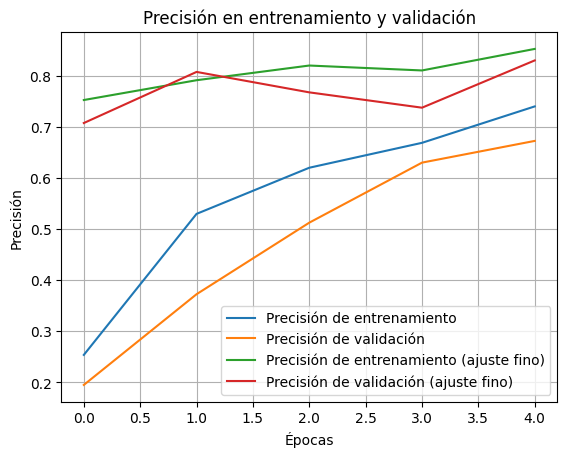

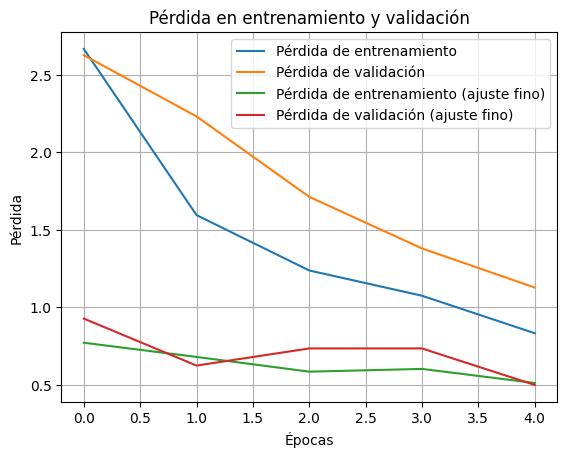

In [11]:
# Graficar curvas de precisión y pérdida
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history_fine.history['accuracy'], label='Precisión de entrenamiento (ajuste fino)')
plt.plot(history_fine.history['val_accuracy'], label='Precisión de validación (ajuste fino)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión en entrenamiento y validación')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.plot(history_fine.history['loss'], label='Pérdida de entrenamiento (ajuste fino)')
plt.plot(history_fine.history['val_loss'], label='Pérdida de validación (ajuste fino)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida en entrenamiento y validación')
plt.grid(True)
plt.show()

Mapa de índice de clases: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


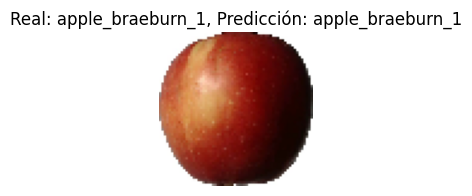

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


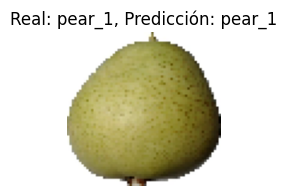

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


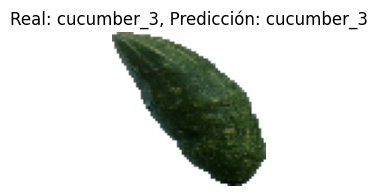

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


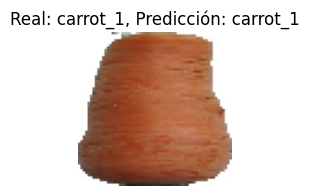

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


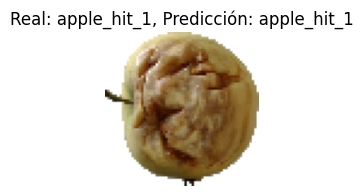

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


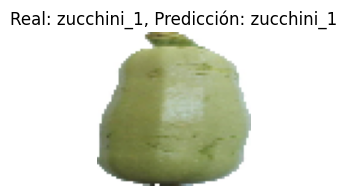

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


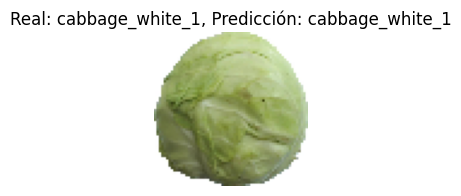

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


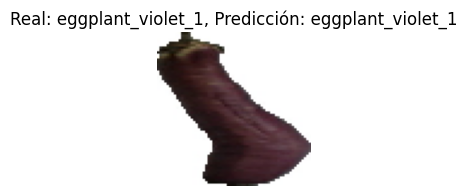

In [12]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Función para obtener el nombre de la clase a partir del índice predicho
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convertir el índice predicho en el nombre de la clase."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Desconocido"  # Valor por defecto si no se encuentra el índice

# Definir la función para visualización
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extraer la etiqueta real dinámicamente desde la estructura de carpetas
    class_name = os.path.basename(os.path.dirname(img_path))  # Extrae el nombre de la carpeta

    # Cargar y preprocesar la imagen
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predecir la clase
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Visualizar la imagen con la predicción
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Real: {class_name}, Predicción: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Obtener el mapeo de índices de clase desde el generador de entrenamiento
class_index_mapping = train_generator.class_indices
print("Mapa de índice de clases:", class_index_mapping)  # Depuración: verificar el mapeo

# Definir una lista de rutas de imágenes sin etiquetas codificadas
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_7.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_107.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/carrot_1/r0_167.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/apple_hit_1/r0_111.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/zucchini_1/r0_43.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cabbage_white_1/r0_59.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/eggplant_violet_1/r0_175.jpg',
]

# Ejecutar las predicciones y visualizaciones
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)